In [1]:
import os
import h5py
import pandas as pd
import torch

from torch_geometric.data import HeteroData
import kamping
import kamping.utils


def load_node_h5(file_path: str):

    with h5py.File(file_path, 'r') as file:
        nodes = file.keys()
        mapping = {index: i for i, index in enumerate(nodes)}
        embedding = [torch.tensor(value) for value in file.values()]
        embedding = torch.stack(embedding)


    return embedding, mapping

def combined_tsv(input_dir: str):
    '''
    This function combines all the CSV files in the input directory into a single DataFrame
    '''
    # if folder is empty raise error
    if not os.listdir(input_dir):
        raise ValueError(f"Folder {input_dir} is empty")
    df = kamping.utils.read_all_tsv_files(input_dir)


def load_edge_csv(file_path: str,
                  protein_mapping:dict, mol_mapping:str):

    # if file_path is a directory, combine all the files in the directory into a single dataframe
    if os.path.isdir(file_path):
        df = kamping.utils.read_all_tsv_files(file_path)
    else:
        df = pd.read_csv(file_path, sep='\t')

    # remove rows with entry1 and entry2 both start with 'cpd:' and type is PCrel
    # remove rows with entry1 and entry2 both start with 'up:' and type is PCrel
    # additional data cleaning
    df = df[~((df['entry1'].str.startswith('cpd:')) & (df['entry2'].str.startswith('cpd:')) & (df['type'] == 'PCrel'))]
    df = df[~((df['entry1'].str.startswith('up:')) & (df['entry2'].str.startswith('up:')) & (df['type'] == 'PCrel'))]
    df = df[~((df['type'] == 'PPrel') & ((df['entry2'].str.startswith('cpd')) | (df['entry1'].str.startswith('cpd'))))]
    # for df_pc if entry2 is a protein, swap entry1 and entry2
    # todo: find a more elegant way to do this
    # add it to parser function
    df.loc[(df['type'] == 'PCrel') & (df['entry2'].str.startswith('up')), ['entry1', 'entry2']] = df.loc[(df['type'] == 'PCrel') & (df['entry2'].str.startswith('up')), ['entry2', 'entry1']].values


    # Remove rows with entry1 or entry2 not in the mapping
    mapping_keys = list(protein_mapping.keys()) + list(mol_mapping.keys())

    # remove prefix from entry1 and entry2
    df['entry1'] = df['entry1'].str.replace(r'^[^:]+:', '', regex=True)
    df['entry2'] = df['entry2'].str.replace(r'^[^:]+:', '', regex=True)

    # remove rows with entry1 or entry2 not in the mapping
    df = df[df['entry1'].isin(mapping_keys) & df['entry2'].isin(mapping_keys)]


    # split df into two parts: one for protein-protein edges and the other for protein-compound edges
    # the PP edges will have type "PPrel"
    # the PC edges will have type "PCrel"
    df_pp = df[df['type'] == 'PPrel']
    df_pc = df[df['type'] == 'PCrel']


    # df_pc edges
    pc_src = [protein_mapping[entry] for entry in df_pc['entry1']]
    pc_dst = [mol_mapping[entry] for entry in df_pc['entry2']]
    pc_index = torch.tensor([pc_src, pc_dst])

    # df_pp edges
    pp_src = [protein_mapping[entry] for entry in df_pp['entry1']]
    pp_dst = [protein_mapping[entry] for entry in df_pp['entry2']]
    pp_index = torch.tensor([pp_src, pp_dst])

    pc_edge_attr = None
    pp_edge_attr = None

    return pc_index, pc_edge_attr, pp_index, pp_edge_attr


In [21]:
# get current working directiory
import os
# set the working directory
os.chdir('/Users/cgu3/Documents/experiments/knext')

protein_x, protein_mapping = load_node_h5('data/embedding/protein_embedding.h5')
mol_x, mol_mapping = load_node_h5('data/embedding/mol_embedding.h5')
pc_edge_index, _, pp_edge_index, _ = load_edge_csv('data/converted/hsa00071.tsv', protein_mapping, mol_mapping)

data = HeteroData()
data['protein'].num_nodes = len(protein_mapping) 
data['protein'].node_type = 0
data['protein'].x = protein_x
data['metabolite'].num_nodes = len(mol_mapping) 
data['metabolite'].node_type = 1

data['metabolite'].x = mol_x
data['protein', 'interact', 'metabolite'].edge_index = pc_edge_index
data['protein', 'interact', 'metabolite'].edge_attr = None
data['protein', 'interact', 'protein'].edge_index = pp_edge_index
data['protein', 'interact', 'protein'].edge_attr = None
# print(data)

In [22]:
import networkx as nx
import  torch_geometric as pyg

data_new = data.to_homogeneous()
print(f'data_new: {data_new}')
nxg = pyg.utils.to_networkx(data_new, node_attrs=['node_type'], to_undirected=True)
nxg.remove_nodes_from(list(nx.isolates(nxg)))
print(f"G node attr: {nx.get_node_attributes(nxg, 'node_type')}")

data_new: Data(edge_index=[2, 1422], x=[8587, 2048], node_type=[8587], edge_type=[1422])
G node attr: {19: 0, 147: 0, 162: 0, 429: 0, 465: 0, 469: 0, 484: 0, 591: 0, 619: 0, 785: 0, 933: 0, 1012: 0, 1014: 0, 1056: 0, 1057: 0, 1103: 0, 1271: 0, 1282: 0, 1547: 0, 1696: 0, 1928: 0, 1982: 0, 1983: 0, 2188: 0, 2272: 0, 2324: 0, 2361: 0, 2519: 0, 2531: 0, 2683: 0, 2951: 0, 2970: 0, 3057: 0, 3059: 0, 3108: 0, 3140: 0, 3207: 0, 3340: 0, 3347: 0, 3395: 0, 3437: 0, 3531: 0, 3541: 0, 3557: 0, 3593: 0, 3633: 0, 3746: 0, 4165: 0, 4484: 0, 4649: 0, 4799: 0, 4949: 0, 5222: 0, 5460: 0, 5586: 0, 6092: 0, 6193: 0, 6202: 0, 6256: 0, 6366: 0, 6639: 0, 7271: 0, 7285: 0, 7520: 0, 7538: 0, 7647: 1, 7679: 1, 7728: 1, 7738: 1, 7744: 1, 7819: 1, 7956: 1, 7993: 1, 8052: 1, 8056: 1, 8080: 1, 8094: 1, 8101: 1, 8210: 1, 8211: 1, 8212: 1, 8213: 1, 8214: 1, 8215: 1, 8216: 1, 8217: 1, 8218: 1, 8219: 1, 8220: 1, 8221: 1, 8222: 1, 8223: 1, 8224: 1, 8225: 1, 8226: 1, 8227: 1, 8228: 1}


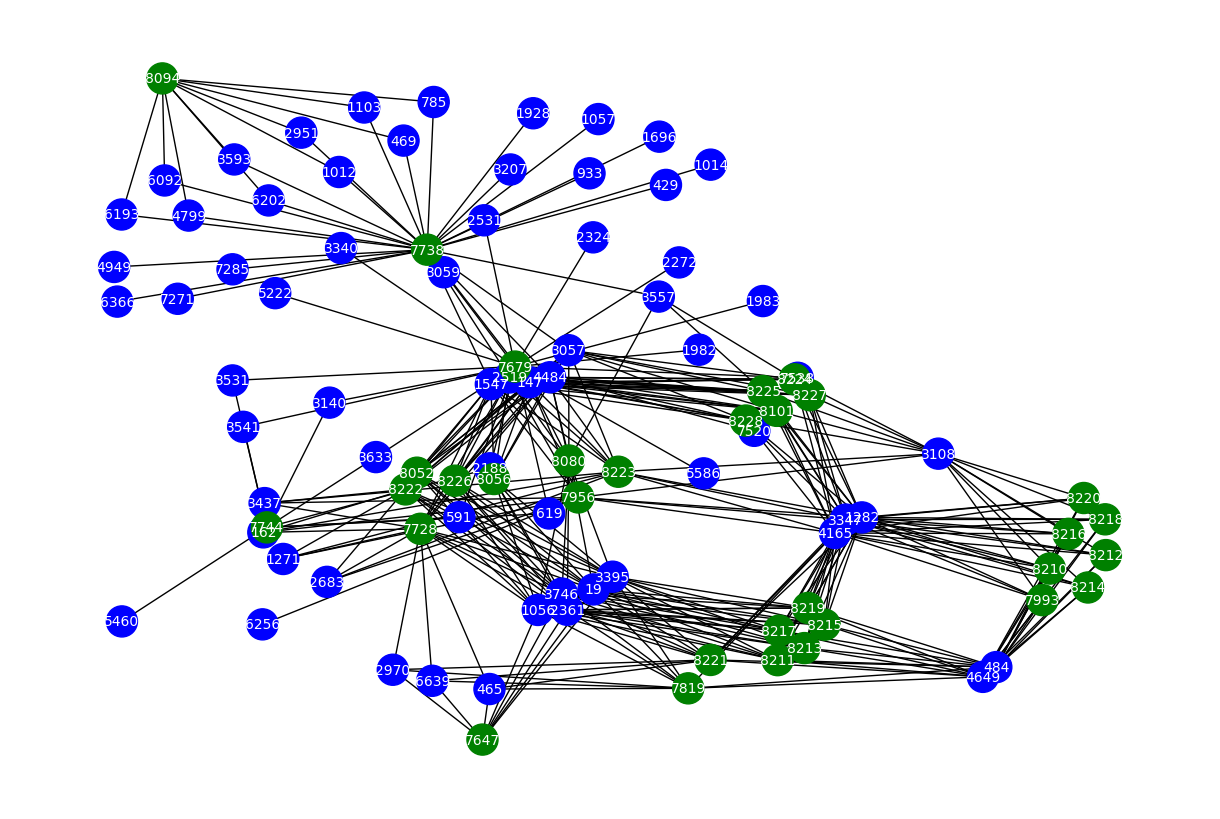

In [23]:
# visualize the graph using networkx with nodes with different node_type having different colors
import matplotlib.pyplot as plt
color_map = {0: 'blue', 1: 'green'}

# Extract node types
node_types = nx.get_node_attributes(nxg, 'node_type')
node_colors = [color_map[node_types[node]] for node in nxg.nodes]

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.kamada_kawai_layout(nxg)  # positions for all nodes
nx.draw(nxg, pos, node_color=node_colors, with_labels=True, node_size=500, font_size=10, font_color='white')
plt.show()